In [47]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
import sys
import pathlib

sys.path.append(str(pathlib.Path().cwd().parent))

In [51]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense

from dataset import Dataset
from plotting import plot_ts

### Пример. Использование полносвязной сети в классической постановке задачи прогнозирования одномерного ряда (n лагов в качестве признаков, 1 лаг в качестве ответа).

#### Возьмем уже известный ряд international-airline-passengers.csv

In [52]:
dataset = Dataset('../data/dataset/')

In [53]:
ts = dataset['alcohol_sales.csv']

In [54]:
ts.head()

0
1992-01-01    3459
1992-02-01    3458
1992-03-01    4002
1992-04-01    4564
1992-05-01    4221
Name: 1, dtype: int64

<Axes: xlabel='0'>

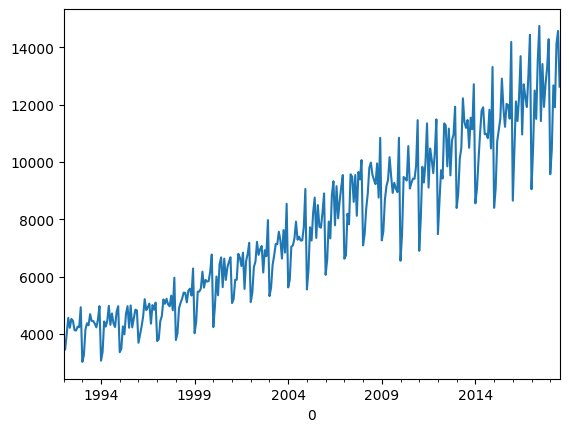

In [55]:
ts.plot()

#### Зададим количество лагов и разобъем на train и test.

In [56]:
num_lags = 12

In [57]:
ts_train, ts_test = ts[:250], ts[250 - num_lags:]

#### Возьмем нашу функцию для перехода к supervised задаче с одной точкой в качестве ответа

In [58]:
def transform_into_matrix(ts: pd.Series, num_lags: int) -> pd.DataFrame:
    """
    Transforms time series into lags matrix to allow
    applying supervised learning algorithms

    Parameters
    ------------
    ts
        Time series to transform
    num_lags
        Number of lags to use

    Returns
    --------
        train, test: np.arrays of shapes (ts-num_lags, num_lags), (num_lags,)
    """

    ts_values = ts.values
    data = {}
    for i in range(num_lags + 1):
        data[f'lag_{num_lags - i}'] = np.roll(ts_values, -i)

    lags_matrix = pd.DataFrame(data)[:-num_lags]
    lags_matrix.index = ts.index[num_lags:]

    return lags_matrix.drop('lag_0', axis=1).values, lags_matrix['lag_0'].values

In [59]:
X_train, y_train = transform_into_matrix(ts_train, num_lags)

In [60]:
X_test, y_test = transform_into_matrix(ts_test, num_lags)

#### Зададим однослойную сеть с 64 нейронами на входном слое, и размерностью, равной количество лагов.

In [61]:
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=num_lags))

#### Зададим выходной слой с одним нейроном

In [62]:
model.add(Dense(1))

#### Скомпилируем и обучим сетку.

In [63]:
model.compile(optimizer='adam', loss='mse')

In [64]:
model.fit(X_train, y_train, epochs=2000, verbose=0)

#### Получим one-step-ahead прогноз на тест

In [65]:
y_pred = model.predict(X_test)

3/3 [==============================] - 0s 726us/step


In [66]:
plot_ts(ts_train, ts_test, pd.Series(y_pred.squeeze(), index=ts_test.index[num_lags:]))

Loading BokehJS ...

#### Мы видим достаточно неплохое качество прогноза, однако каких-то качественных улучшений по сравнению с линейной регрессией, запущенной из коробки мы не видим.

In [67]:
from model import TimeSeriesPredictor

predictor = TimeSeriesPredictor(granularity='P1M', num_lags=12)

In [68]:
predictor.fit(ts_train)

In [69]:
preds = predictor.predict_batch(ts_train, ts_test)

In [70]:
plot_ts(ts, preds)

Loading BokehJS ...

#### Тем не менее, в плане out-of-sample прогноза, запущенная из коробки lr показывает беду

In [71]:
preds_out_of_sample = predictor.predict_next(ts_train, len(ts_test))

In [72]:
plot_ts(ts, preds_out_of_sample)

Loading BokehJS ...

In [73]:
plot_ts(ts_test[12:][:48], preds_out_of_sample[:-12][:48])

Loading BokehJS ...

## Решение - попробуем сформировать датасет так, чтобы учиться предсказать сразу 12 точек! Для этого как раз удобно использовать полносвязную сеть.

### Задание 1. Использование полносвязной сети для предсказания следующих 12 точек

### Задача - по предыдущем n точкам научиться предсказывать следующие m точек

In [89]:
ts = dataset['alcohol_sales.csv']

### 1) Реализовать функцию разбиения одномерного ряда на входные данные для сетки

* принимает на вход ряд, количество входных и выходных лагов
* функция должна пройтись скользящим оконом ширины num_lags_in по временному ряду и для каждой итерации получить в качестве ответов следующие num_lags_out количество лагов
* каждый раз окно сдвигается на 1 лаг
* возращает два np.array X, y

In [90]:
from typing import Tuple

def transform_ts_into_matrix(ts: pd.Series, num_lags_in: int, num_lags_out: int) -> Tuple[np.array, np.array]:
    """
    Данная функция должна пройтись скользящим окном по временному ряду и для каждых
    num_lags_in точек в качестве признаков собрать num_lags_out следующих точек в качестве таргета.
    
    Вернуть два np.array массива из X_train и y_train соответственно
    """
    sequence = ts.values
    X, y = list(), list()
    i = 0
    outer_idx = num_lags_out
    while outer_idx < len(sequence):
        inner_idx = i + num_lags_in
        outer_idx = inner_idx + num_lags_out
        X_, y_ = sequence[i:inner_idx], sequence[inner_idx:outer_idx]
        X.append(X_)
        y.append(y_)
        i += 1
    return np.array(X), np.array(y)

#### 2) Разбить на трейн и тест, отложив в качестве теста последние 12 точек (обратите внимание, что в таком случае в  качестве X_test и y_test у вас будет всего один объект)

In [91]:
# ваш код здесь
num_lags = 24
num_output = 12
X, y = transform_ts_into_matrix(ts, num_lags, num_output)

In [92]:
X_train, y_train = X[:-(num_lags+1)], y[:-(num_lags+1)]
X_test, y_test = X[[-1, -(num_lags+1)]], y[[-1, -(num_lags+1)]]

#### 3) Построить полносвязную сеть, указав нужное количество входных и выходных слоев

* в качестве архитектуры возьмите популярную конфигурацию слоев с 64 и 32 нейронами
* на первом слое необходимо указать входную размерность, равную количеству лагов на входе
* на выходном слое необхдимо указать количество нейронов, равное количеству выходных лагов
* activation, optimizer, loss можете выбрать сами, по умолчанию 'relu', 'adam', 'mse'

In [93]:
# ваш код здесь
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=num_lags))
# model.add(Dense(32, activation='relu'))
model.add(Dense(num_output))
model.compile(optimizer='adam', loss='mse')

#### 4) Обучить сеть.

In [104]:
#ваш код здесь
model.fit(X_train, y_train, epochs=700, verbose=0, validation_data=(X_test, y_test))

#### 5) Сделайте предикт на тесте и сравните результат с предыдущим подходом

In [105]:
# ваш код здесь
y_pred = model.predict(X_test)

1/1 [==============================] - 0s 8ms/step


In [106]:
plot_ts(ts, pd.Series(y_pred.flatten(), index=ts.index[-num_output*2:]))

Loading BokehJS ...

In [83]:
from sklearn.metrics import mean_squared_error as mse

In [84]:
mse(y_pred.flatten(), y_test.flatten())

455171.43387599784

### Использование полносвязной сети для предсказания многомерного ряда

In [107]:
ts = pd.read_csv('../data/stability_index.csv', index_col='timestamp', parse_dates=True)

In [108]:
ts.head()

,1,2,3,4,5,6,7,8,9
timestamp,,,,,,,,,
2020-01-15 13:00:00,205.0,92.0,63.0,55.0,26.0,27.0,20.0,34.0,155.0
2020-01-15 14:00:00,173.0,97.0,69.0,44.0,31.0,22.0,41.0,26.0,182.0
2020-01-15 15:00:00,145.0,83.0,73.0,58.0,40.0,25.0,31.0,19.0,167.0
2020-01-15 16:00:00,84.0,60.0,53.0,39.0,32.0,31.0,19.0,15.0,102.0
2020-01-15 17:00:00,117.0,77.0,40.0,53.0,33.0,29.0,21.0,30.0,160.0


<Axes: xlabel='timestamp'>

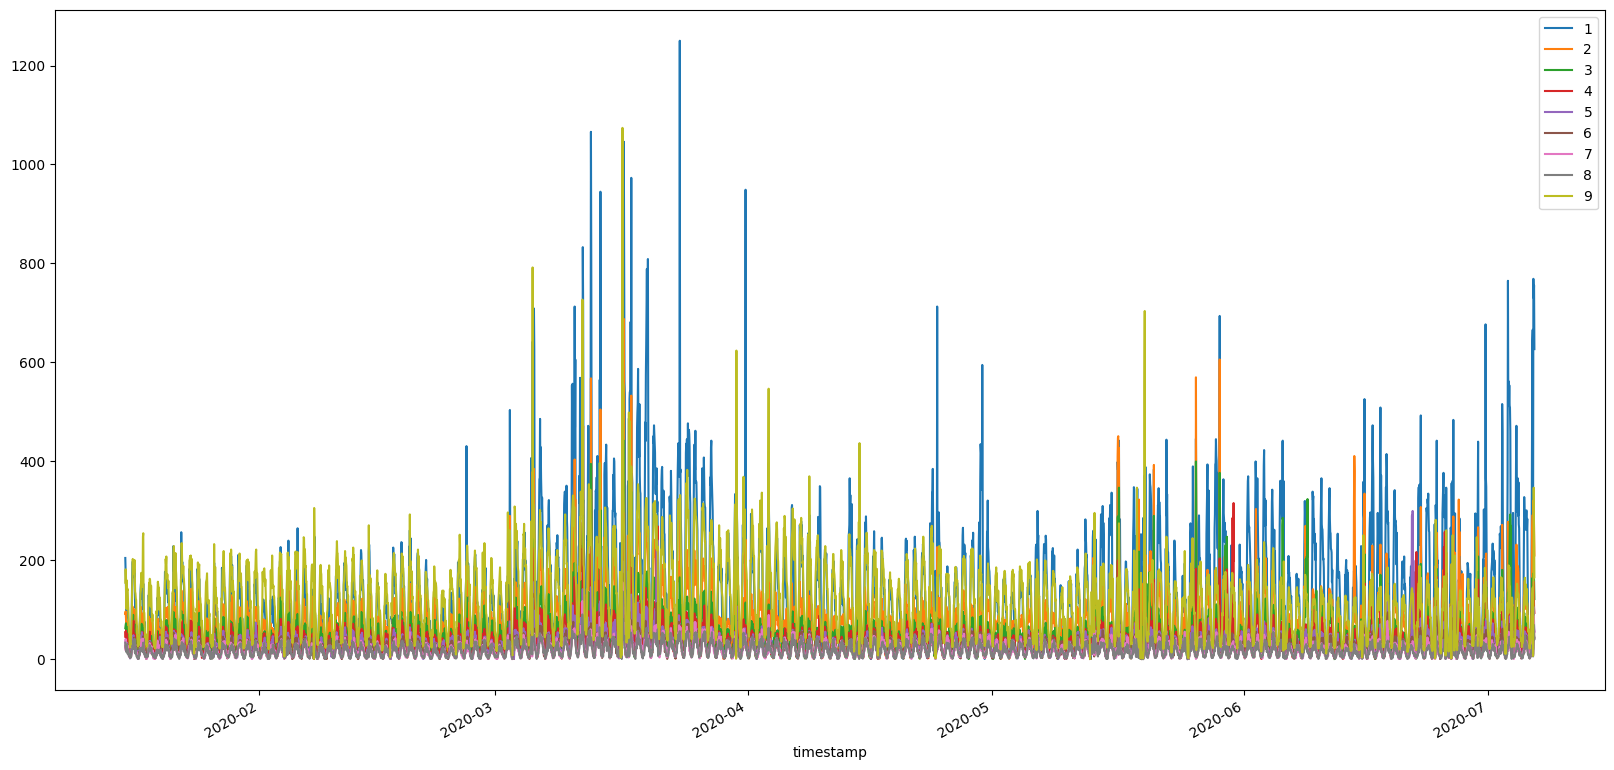

In [109]:
ts.plot(figsize=(20, 10))

In [110]:
ts.fillna(ts.median(), inplace=True)

#### 1) Реализовать функцию, которая разбивает исходный ряд на входные данные X и y для сетки

In [111]:
def transform_multi_ts_into_matrix(ts: pd.DataFrame, num_lags: int):
    """
    Данная функция должна пройтись скользящим окном по временному ряду
    и собрать в качестве признаков X np.array размерности (len(ts)-num_lags, n_dims, num_lags),
    а в качестве y np.array размерности (len(ts)-num_lags, n_dims),
    где n_dims - размерность многомерного ряда.
    
    То есть для всех компонент временного ряда мы должны взять num_lags предыдущих точек каждой компонент
    в качестве признаков и все компоненты текущей точки в качестве target
    """
    sequence = ts.values
    X, y = list(), list()
    i = 0
    end_i = num_lags
    while end_i < len(sequence): 
        seq_x, seq_y = sequence[i:end_i], sequence[end_i]
        X.append(seq_x.T.flatten())
        y.append(seq_y)
        i += 1
        end_i = i + num_lags
    return np.array(X), np.array(y)

In [112]:
n_lags = 14

In [113]:
X, y = transform_multi_ts_into_matrix(ts, n_lags)

#### 2) Разбить на трейн и тест

In [114]:
# ваш код здесь
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

#### 3) Построить полносвязную сеть, указав нужное количество входных и выходных слоев

In [115]:
# ваш код здесь
n_dims = 9

model = Sequential()
model.add(Dense(64, activation='relu', input_dim=n_dims*n_lags))
model.add(Dense(32, activation='relu'))
model.add(Dense(n_dims))
model.compile(optimizer='adam', loss='mse')

####  4) Обучить модель 

In [116]:
# ваш код здесь
model.fit(X_train, y_train, epochs=200)

Epoch 1/200
104/104 [==============================] - 0s 590us/step - loss: 1888.5021
Epoch 2/200
104/104 [==============================] - 0s 609us/step - loss: 1145.7255
Epoch 3/200
104/104 [==============================] - 0s 615us/step - loss: 1050.1622
Epoch 4/200
104/104 [==============================] - 0s 621us/step - loss: 1007.5530
Epoch 5/200
104/104 [==============================] - 0s 625us/step - loss: 958.6027
Epoch 6/200
104/104 [==============================] - 0s 617us/step - loss: 932.3917
Epoch 7/200
104/104 [==============================] - 0s 624us/step - loss: 907.9711
Epoch 8/200
104/104 [==============================] - 0s 666us/step - loss: 878.3873
Epoch 9/200
104/104 [==============================] - 0s 740us/step - loss: 850.5361
Epoch 10/200
104/104 [==============================] - 0s 698us/step - loss: 834.7283
Epoch 11/200
104/104 [==============================] - 0s 683us/step - loss: 813.6596
Epoch 12/200
104/104 [==========================

In [117]:
preds = model.predict(X_test)

26/26 [==============================] - 0s 513us/step


In [118]:
plot_ts(ts['1'], pd.Series(preds[:,0], index=ts['1'].index[-len(preds):]))

Loading BokehJS ...

In [224]:
len(preds)

827

In [120]:
def transform_multi_ts_into_matrix_long(ts, num_lags_in, num_lags_out, target=0):
    sequence = ts.values
    X, y = list(), list()
    i = 0
    inner_i = 0
    outer_i = 0
    while outer_i < len(ts):
        inner_i = i + num_lags_in
        outer_i = inner_i + num_lags_out
        X_ = sequence[i:inner_i]
        y_ = sequence[:, target][inner_i:outer_i]
        X.append(X_)
        y.append(y_)
        i += 1

    return np.array(X), np.array(y)

In [122]:
X, y = transform_multi_ts_into_matrix_long(ts, 24, 12)

In [124]:
y.shape

(4110, 12)